In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm
from statsmodels.tools import add_constant
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

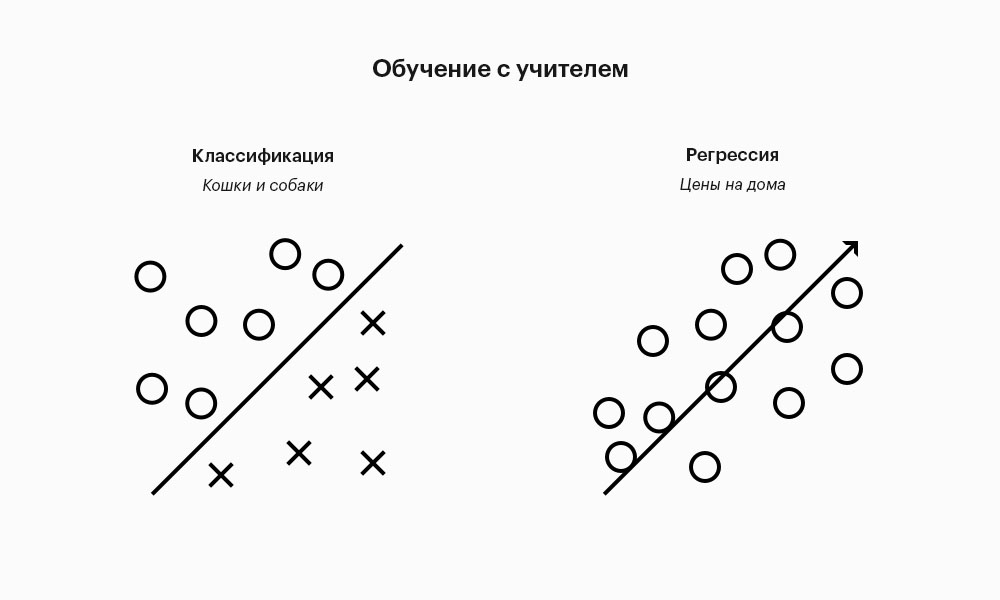

Задача классификации – получение категориального ответа на основе набора признаков. Задано конечное множество объектов, для которых известно, к каким классам они относятся. ЗАРАНЕЕ ЗНАЕМ МЕТКИ КЛАССА - РЕШАЕМ ЗАДАЧУ КЛАССИФИКАЦИИ.

Мультиклассовая классификация (случай когда классов более 2)

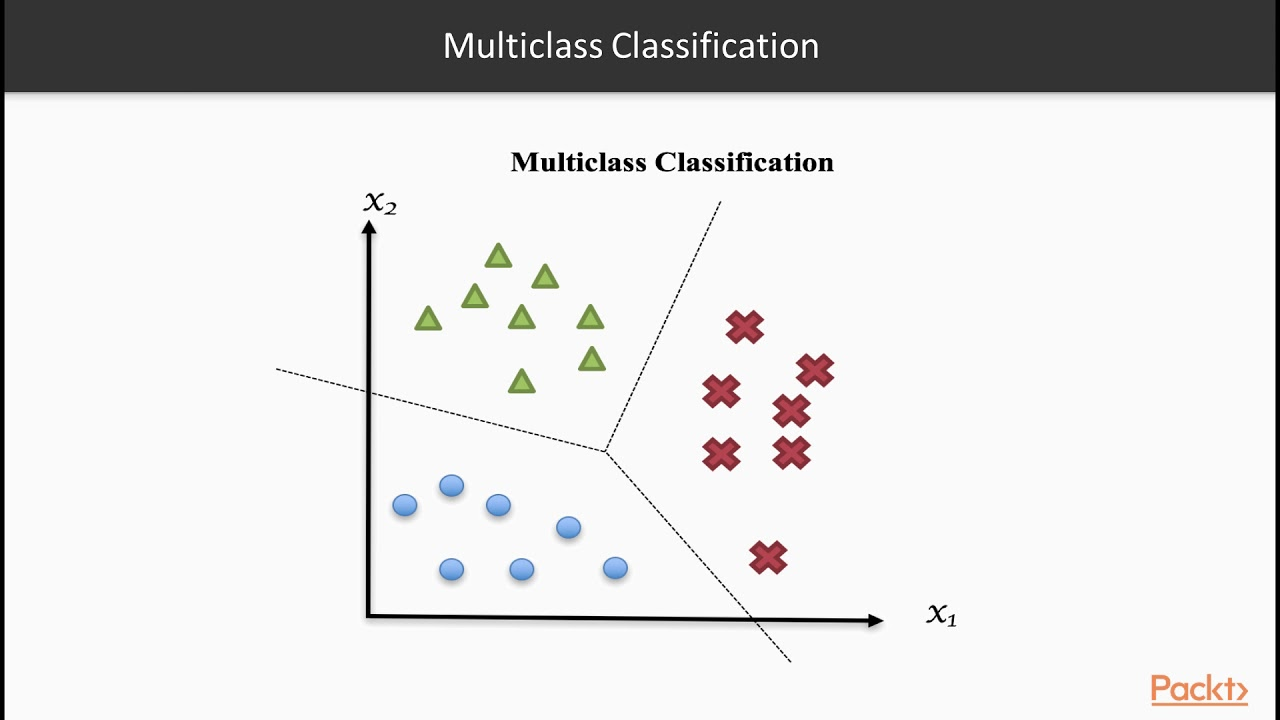

Основные алгоритмы классификации:

* Логистическая регрессия (Logistic Regression)
* Алгоритм k-ближайших соседей (K-Nearest Neighbors)
* Дерево решений и Случайный лес (Decision Tree and Random Forest)
* Метод опорных векторов(Support Vector Machine)
* Градиентный бустинг (Gradient Boosting)
* и т.д....

## Логистическая регрессия

Логистическая регрессия схожа с линейной, за исключением того факта, что вместо вычисления значения у, она оценивает к какой категории принадлежит данная точка данных.

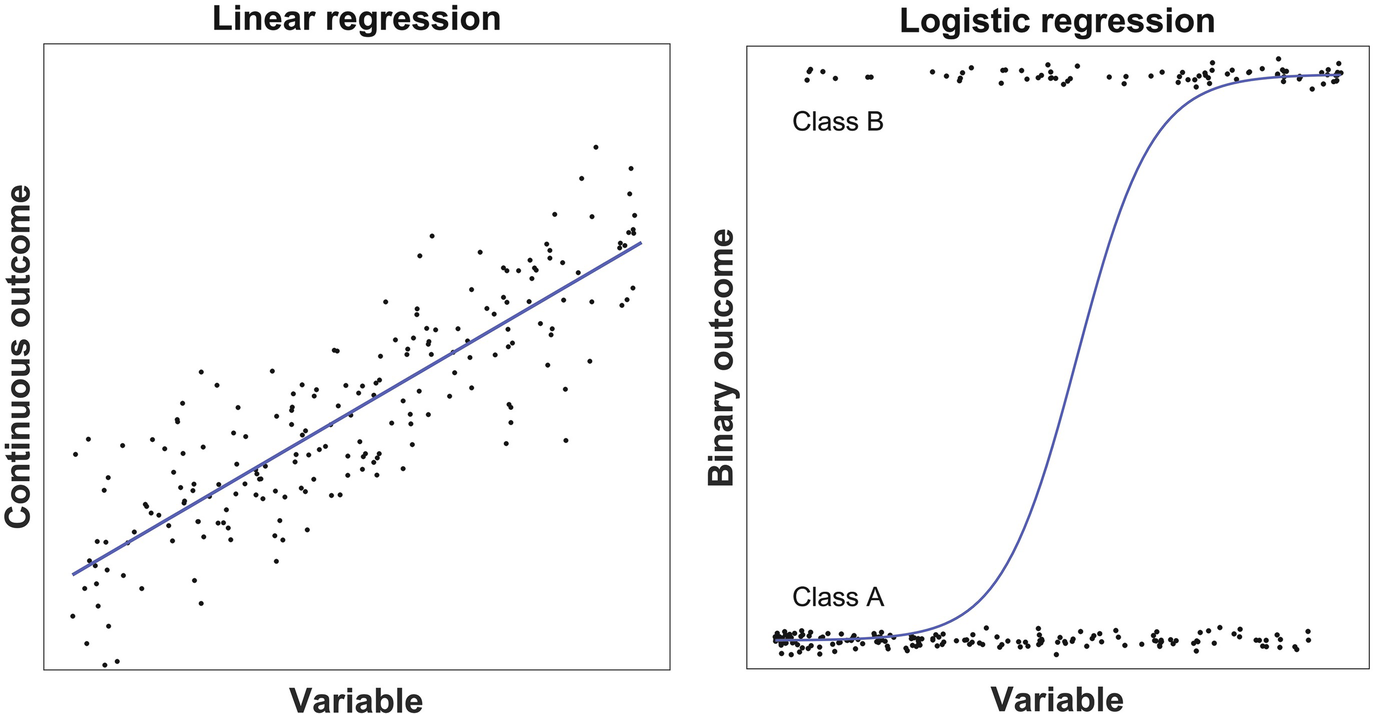

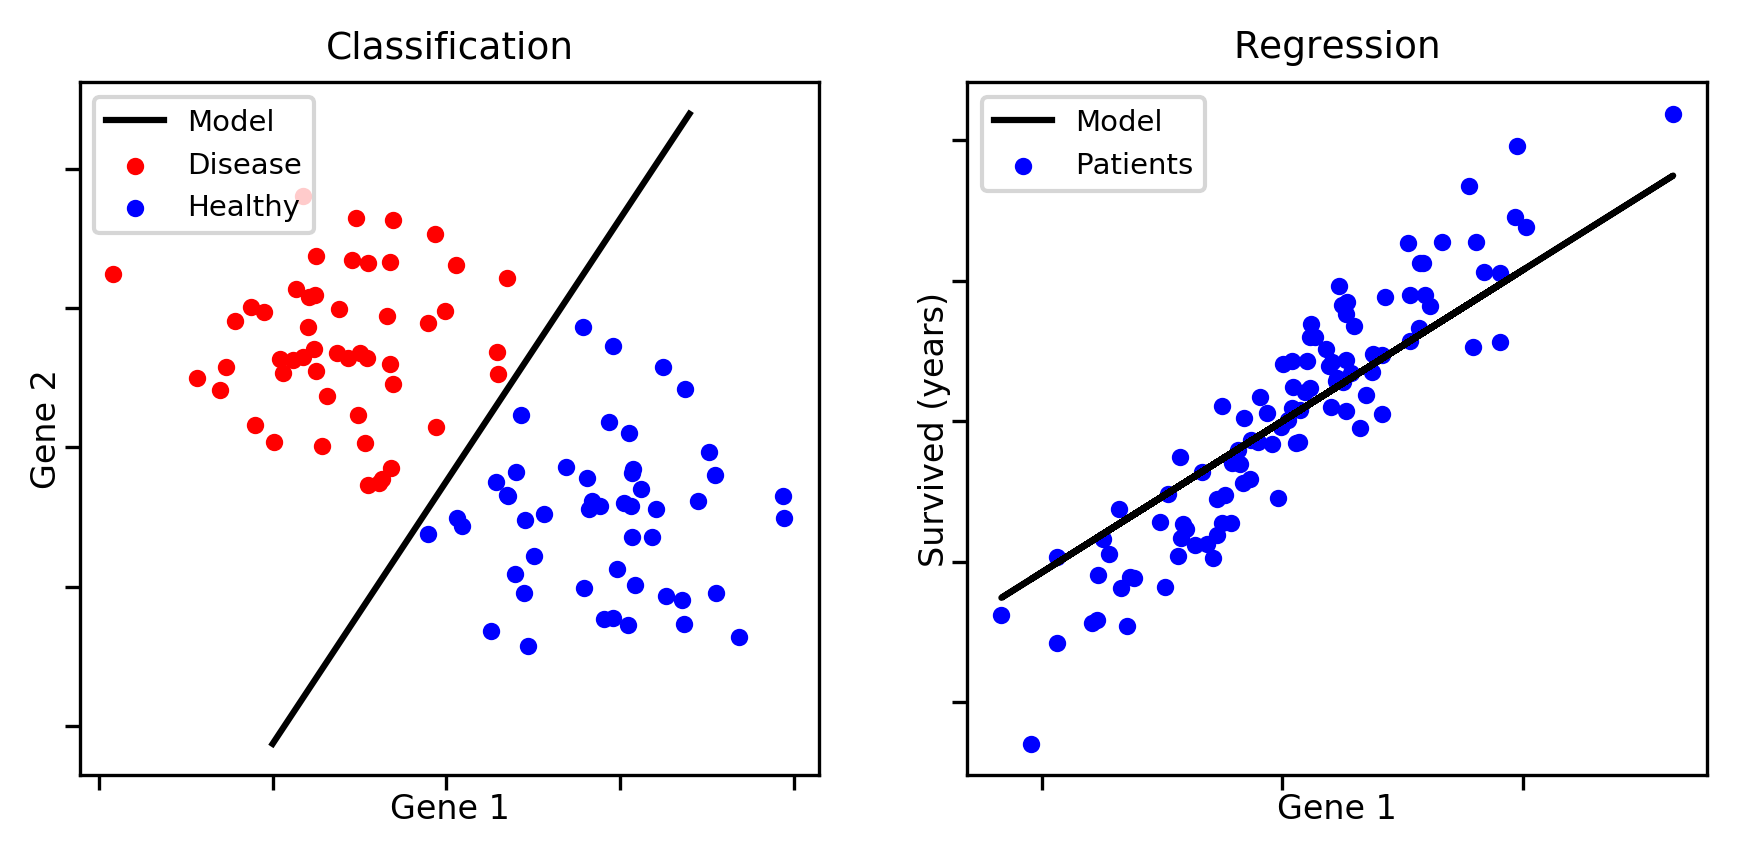

Функция логистической регрессии

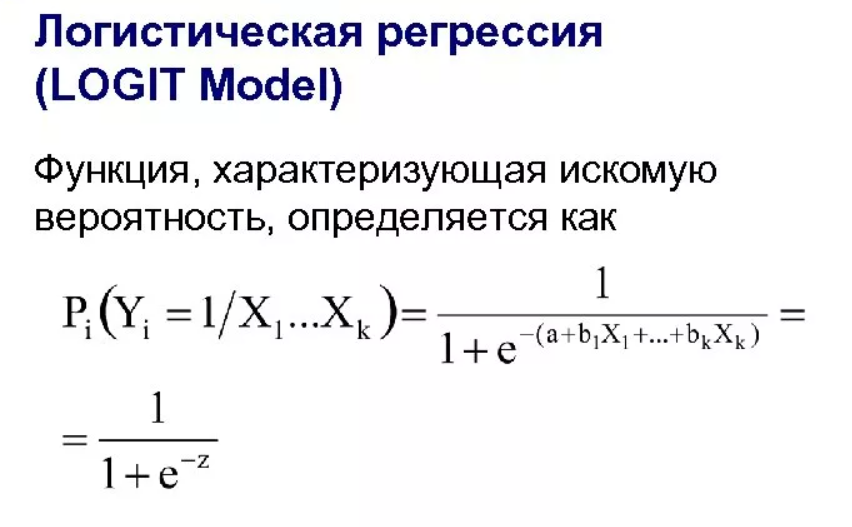

Главная фишка логита (лог.регрессии) в том, что в её основе используется нелинейная функция - сигмоида

Прелесть сигмоиды в том, что какие бы не были признаки на входе, сигмоида всегда возвращает значение в диапазоне от 0 до 1. В нашем случае это будет вероятность принадлежности к первому классу.

Если вероятность больше 0,5 (по умолчанию), то модель делает вывод о том, что перед нами объект 1 класса, в противном случае перед нами класс 0.

## Логит на данных (снова плывем на Титанике) - бинарная классификация

In [2]:
titanic = pd.read_csv('/content/drive/MyDrive/Введение в ML ITHUB/lessons/data/titanic.csv')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


* Pclass — класс пассажира (1 — высший, 2 — средний, 3 — низший);
* Name — имя;
* Sex — пол;
* Age — возраст;
* SibSp — количество братьев, сестер, сводных братьев, сводных сестер, супругов на борту титаника;
* Parch — количество родителей, детей (в том числе приемных) на борту титаника;
* Ticket — номер билета;
* Fare — плата за проезд;
* Cabin — каюта;
* Embarked — порт посадки (C — Шербур; Q — Квинстаун; S — Саутгемптон).

Будем решать судьбы - определять кто выживет на титанике

In [3]:
#предобработка данных

#map для Sex
titanic['Sex']=titanic['Sex'].map({'male':1,'female':0})

#кодирование категориальных признаков [Pclass,Embarked]
def encode_features(df,features):
  df_encode = pd.DataFrame()
  for f in features:
    ohe = OneHotEncoder()
    ohe_arr = ohe.fit_transform(df[[f]])
    ohe_df=pd.DataFrame(ohe_arr.toarray(), columns=ohe.get_feature_names_out())
    df_encode = pd.concat([df_encode,ohe_df],axis=1)
  return df_encode
enc_features = encode_features(titanic,['Pclass','Embarked'])
enc_features.head()

,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [4]:
#соединяем все вместе
titanic_df = titanic[['Survived','Sex','Age','SibSp','Parch','Fare']]
titanic_df = pd.concat([titanic_df,enc_features],axis=1)
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Survived      891 non-null    int64  
 1   Sex           891 non-null    int64  
 2   Age           714 non-null    float64
 3   SibSp         891 non-null    int64  
 4   Parch         891 non-null    int64  
 5   Fare          891 non-null    float64
 6   Pclass_1      891 non-null    float64
 7   Pclass_2      891 non-null    float64
 8   Pclass_3      891 non-null    float64
 9   Embarked_C    891 non-null    float64
 10  Embarked_Q    891 non-null    float64
 11  Embarked_S    891 non-null    float64
 12  Embarked_nan  891 non-null    float64
dtypes: float64(9), int64(4)
memory usage: 90.6 KB


In [5]:
titanic_df=titanic_df.drop([titanic_df.columns[-1]],axis=1).dropna()
titanic_df

,Survived,Sex,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,0,1,22.0,1,0,7.2500,0.0,0.0,1.0,0.0,0.0,1.0
1,1,0,38.0,1,0,71.2833,1.0,0.0,0.0,1.0,0.0,0.0
2,1,0,26.0,0,0,7.9250,0.0,0.0,1.0,0.0,0.0,1.0
3,1,0,35.0,1,0,53.1000,1.0,0.0,0.0,0.0,0.0,1.0
4,0,1,35.0,0,0,8.0500,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
885,0,0,39.0,0,5,29.1250,0.0,0.0,1.0,0.0,1.0,0.0
886,0,1,27.0,0,0,13.0000,0.0,1.0,0.0,0.0,0.0,1.0
887,1,0,19.0,0,0,30.0000,1.0,0.0,0.0,0.0,0.0,1.0
889,1,1,26.0,0,0,30.0000,1.0,0.0,0.0,1.0,0.0,0.0


In [6]:
#делим на X и Y
Y = titanic_df['Survived']
X = titanic_df.drop(['Survived'],axis=1)

In [8]:
log_reg = sm.Logit(Y, add_constant(X[['Sex','Fare']])).fit()
print(log_reg.summary2())

Optimization terminated successfully.
         Current function value: 0.503325
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.255     
Dependent Variable: Survived         AIC:              724.7484  
Date:               2023-03-31 06:05 BIC:              738.4611  
No. Observations:   714              Log-Likelihood:   -359.37   
Df Model:           2                LL-Null:          -482.26   
Df Residuals:       711              LLR p-value:      4.2880e-54
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
-------------------------------------------------------------------
          Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
const     0.6626     0.1676     3.9525   0.0001    0.3340    0.9912
Sex      -2.3780     0.1892   -12.5661   0.0000   -2.7489 

In [ ]:
#какие признаки статистически значимы?

In [9]:
#создание модели с помощью scikit-learn
clf = LogisticRegression()

логит в sklearn - https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

Два основных параметра, которые можно изменять в модели логистической регрессии:
* C
* solver

In [10]:
#гиперпараметры
C_values = [0.001, 0.01, 0.1, 10, 100, 1000]
solvers = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'] 

In [11]:
#пример
clf = LogisticRegression(penalty='l2',C=0.1,solver='lbfgs',max_iter=10000)

In [12]:
#кросс-валидация, метрика - точность
scores = cross_validate(clf, X, Y, cv=10,scoring=('accuracy'))
scores['test_score'].mean().round(2)

0.79

In [13]:
#тюнинг модели - подбор наилучших параметров
for c in C_values:
  for s in solvers:
    clf = LogisticRegression(penalty='l2',C=c,solver=s,max_iter=10000)
    scores = cross_validate(clf, X, Y, cv=10,scoring=('accuracy'))
    print(f'{c},{s} - ',scores['test_score'].mean().round(2))

0.001,lbfgs -  0.67
0.001,liblinear -  0.67
0.001,newton-cg -  0.67
0.001,newton-cholesky -  0.67
0.001,sag -  0.68
0.001,saga -  0.68
0.01,lbfgs -  0.73
0.01,liblinear -  0.72
0.01,newton-cg -  0.73
0.01,newton-cholesky -  0.73
0.01,sag -  0.72
0.01,saga -  0.71
0.1,lbfgs -  0.8
0.1,liblinear -  0.8
0.1,newton-cg -  0.8
0.1,newton-cholesky -  0.8
0.1,sag -  0.8
0.1,saga -  0.78
10,lbfgs -  0.79
10,liblinear -  0.79
10,newton-cg -  0.79
10,newton-cholesky -  0.79
10,sag -  0.79
10,saga -  0.79
100,lbfgs -  0.79
100,liblinear -  0.79
100,newton-cg -  0.79
100,newton-cholesky -  0.79
100,sag -  0.79
100,saga -  0.79
1000,lbfgs -  0.79
1000,liblinear -  0.79
1000,newton-cg -  0.79
1000,newton-cholesky -  0.79
1000,sag -  0.79
1000,saga -  0.79


In [14]:
clf_final = LogisticRegression(penalty='l2',C=0.1,solver='lbfgs',max_iter=10000)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
clf_final.fit(X_train,y_train)

LogisticRegression(C=0.1, max_iter=10000)

In [16]:
#коэффициенты при признаках
coefs=pd.DataFrame()
coefs['coef']=clf_final.coef_[0]
coefs['column']=X.columns
print('Свободный член:',clf_final.intercept_)
coefs

Свободный член: [1.54689138]


,coef,column
0,-1.617772,Sex
1,-0.029183,Age
2,-0.304695,SibSp
3,0.044758,Parch
4,0.008326,Fare
5,0.559039,Pclass_1
6,0.127758,Pclass_2
7,-0.686260,Pclass_3
8,0.161219,Embarked_C
9,-0.033999,Embarked_Q


In [17]:
log_reg = sm.Logit(Y, add_constant(X)).fit()
print(log_reg.summary2())

         Current function value: 0.442816
         Iterations: 35
                               Results: Logit
Model:                  Logit                Pseudo R-squared:     0.344     
Dependent Variable:     Survived             AIC:                  654.3419  
Date:                   2023-03-31 06:15     BIC:                  704.6216  
No. Observations:       714                  Log-Likelihood:       -316.17   
Df Model:               10                   LL-Null:              -482.26   
Df Residuals:           703                  LLR p-value:          2.4042e-65
Converged:              0.0000               Scale:                1.0000    
No. Iterations:         35.0000                                              
-----------------------------------------------------------------------------
            Coef.     Std.Err.      z     P>|z|      [0.025         0.975]   
-----------------------------------------------------------------------------
const       15.2206 5800028.82

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [23]:
#предсказание 
y_pred = clf_final.predict(X_test)

for i in range(10):
  print(f'Модель - {y_pred[i]},Истинная метка - {y_test.values[i]}')

Модель - 0,Истинная метка - 0
Модель - 1,Истинная метка - 0
Модель - 1,Истинная метка - 1
Модель - 0,Истинная метка - 0
Модель - 1,Истинная метка - 1
Модель - 0,Истинная метка - 0
Модель - 0,Истинная метка - 0
Модель - 0,Истинная метка - 0
Модель - 0,Истинная метка - 0
Модель - 0,Истинная метка - 0


In [22]:
y_pred_proba = clf_final.predict_proba(X_test)
y_pred_proba

array([[0.55965649, 0.44034351],
       [0.25978528, 0.74021472],
       [0.20347571, 0.79652429],
       [0.67376808, 0.32623192],
       [0.46495393, 0.53504607],
       [0.88182434, 0.11817566],
       [0.73738194, 0.26261806],
       [0.66522901, 0.33477099],
       [0.79098887, 0.20901113],
       [0.64421587, 0.35578413],
       [0.81406787, 0.18593213],
       [0.49399197, 0.50600803],
       [0.25700627, 0.74299373],
       [0.86264459, 0.13735541],
       [0.71262101, 0.28737899],
       [0.48510954, 0.51489046],
       [0.72054988, 0.27945012],
       [0.35533308, 0.64466692],
       [0.43891537, 0.56108463],
       [0.75329243, 0.24670757],
       [0.80617406, 0.19382594],
       [0.38406264, 0.61593736],
       [0.20213709, 0.79786291],
       [0.8800298 , 0.1199702 ],
       [0.84685219, 0.15314781],
       [0.35533308, 0.64466692],
       [0.0873939 , 0.9126061 ],
       [0.52179413, 0.47820587],
       [0.57580961, 0.42419039],
       [0.66278341, 0.33721659],
       [0.

## Стандартизация данных

In [ ]:
#standard scaler - cтандартизирует характеристики, удалив среднее значение и масштабировав до единичной дисперсии.

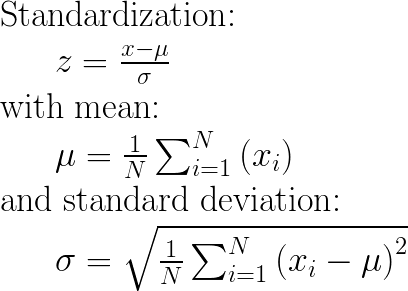

In [24]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
stand_scal_X = scaler.fit_transform(X)

In [ ]:
for c in C_values:
  for s in solvers:
    clf = LogisticRegression(penalty='l2',C=c,solver=s,max_iter=10000)
    scores = cross_validate(clf, stand_scal_X, Y, cv=10,scoring=('accuracy'))
    print(f'{c},{s} - ',scores['test_score'].mean().round(2))

0.001,lbfgs -  0.68
0.001,liblinear -  0.76
0.001,newton-cg -  0.68
0.001,newton-cholesky -  0.68
0.001,sag -  0.68
0.001,saga -  0.68
0.01,lbfgs -  0.8
0.01,liblinear -  0.78
0.01,newton-cg -  0.8
0.01,newton-cholesky -  0.8
0.01,sag -  0.8
0.01,saga -  0.8
0.1,lbfgs -  0.79
0.1,liblinear -  0.79
0.1,newton-cg -  0.79
0.1,newton-cholesky -  0.79
0.1,sag -  0.79
0.1,saga -  0.79
10,lbfgs -  0.79
10,liblinear -  0.79
10,newton-cg -  0.79
10,newton-cholesky -  0.79
10,sag -  0.79
10,saga -  0.79
100,lbfgs -  0.79
100,liblinear -  0.79
100,newton-cg -  0.79
100,newton-cholesky -  0.79
100,sag -  0.79
100,saga -  0.79
1000,lbfgs -  0.79
1000,liblinear -  0.79
1000,newton-cg -  0.79
1000,newton-cholesky -  0.79
1000,sag -  0.79
1000,saga -  0.79


In [ ]:
#minmaxscaler

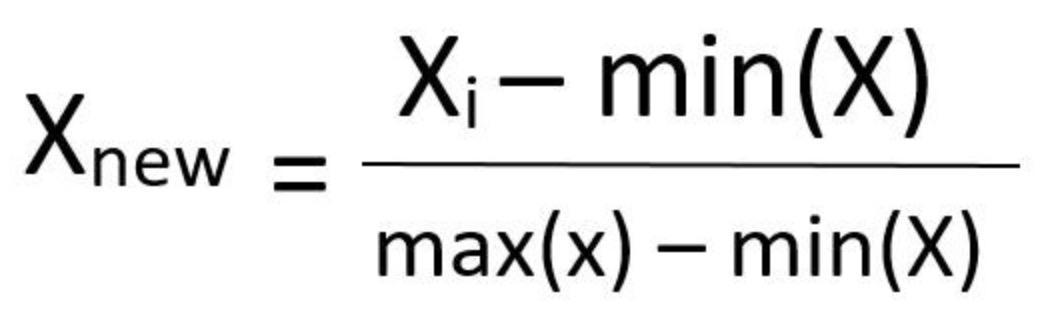

In [25]:
from sklearn.preprocessing import MinMaxScaler
scaler_min_max = MinMaxScaler()
minmax_scal_X = scaler_min_max.fit_transform(X)

In [26]:
minmax_scal_X

array([[1.        , 0.27117366, 0.2       , ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.4722292 , 0.2       , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.32143755, 0.        , ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.        , 0.23347575, 0.        , ..., 0.        , 0.        ,
        1.        ],
       [1.        , 0.32143755, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [1.        , 0.39683338, 0.        , ..., 0.        , 1.        ,
        0.        ]])

In [ ]:
for c in C_values:
  for s in solvers:
    clf = LogisticRegression(penalty='l2',C=c,solver=s,max_iter=10000)
    scores = cross_validate(clf, minmax_scal_X, Y, cv=10,scoring=('accuracy'))
    print(f'{c},{s} - ',scores['test_score'].mean().round(2))

0.001,lbfgs -  0.59
0.001,liblinear -  0.63
0.001,newton-cg -  0.59
0.001,newton-cholesky -  0.59
0.001,sag -  0.59
0.001,saga -  0.59
0.01,lbfgs -  0.79
0.01,liblinear -  0.78
0.01,newton-cg -  0.79
0.01,newton-cholesky -  0.79
0.01,sag -  0.79
0.01,saga -  0.79
0.1,lbfgs -  0.78
0.1,liblinear -  0.79
0.1,newton-cg -  0.78
0.1,newton-cholesky -  0.78
0.1,sag -  0.78
0.1,saga -  0.78
10,lbfgs -  0.79
10,liblinear -  0.79
10,newton-cg -  0.79
10,newton-cholesky -  0.79
10,sag -  0.79
10,saga -  0.79
100,lbfgs -  0.79
100,liblinear -  0.79
100,newton-cg -  0.79
100,newton-cholesky -  0.79
100,sag -  0.79
100,saga -  0.79
1000,lbfgs -  0.79
1000,liblinear -  0.79
1000,newton-cg -  0.79
1000,newton-cholesky -  0.79
1000,sag -  0.79
1000,saga -  0.79


In [ ]:
clf_final_scaled = LogisticRegression(penalty='l2',C=0.01,solver='lbfgs',max_iter=10000)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(minmax_scal_X, Y, test_size=0.2, random_state=0)
clf_final_scaled.fit(X_train,y_train)

LogisticRegression(C=0.01, max_iter=10000)

In [ ]:
coefs=pd.DataFrame()
coefs['coef']=clf_final_scaled.coef_[0]
coefs['column']=X.columns
print('Свободный член:',clf_final_scaled.intercept_)
coefs

Свободный член: [0.0429405]


,coef,column
0,-0.513996,Sex
1,-0.050421,Age
2,-0.010117,SibSp
3,0.034663,Parch
4,0.056050,Fare
5,0.227596,Pclass_1
6,0.051958,Pclass_2
7,-0.279555,Pclass_3
8,0.109709,Embarked_C
9,-0.012013,Embarked_Q


In [ ]:
log_reg = sm.Logit(Y, add_constant(minmax_scal_X)).fit()
print(log_reg.summary2())

         Current function value: 0.442816
         Iterations: 35
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.344     
Dependent Variable: Survived         AIC:              654.3419  
Date:               2023-03-31 02:46 BIC:              704.6216  
No. Observations:   714              Log-Likelihood:   -316.17   
Df Model:           10               LL-Null:          -482.26   
Df Residuals:       703              LLR p-value:      2.4042e-65
Converged:          0.0000           Scale:            1.0000    
No. Iterations:     35.0000                                      
-----------------------------------------------------------------
        Coef.    Std.Err.     z     P>|z|     [0.025     0.975]  
-----------------------------------------------------------------
const   15.2070        nan      nan    nan         nan        nan
x1      -2.6379     0.2230 -11.8287 0.0000     -3.0749    -2.2008
x2      -3.4465     0.6623  -5.2039 

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
